In [1]:
# -*- coding: utf-8 -*-
# author: Yabin Zheng
# Email: sczhengyabin@hotmail.com

%matplotlib inline

import re
from bs4 import BeautifulSoup
import sys
import time
import random
import json
import requests
import pandas as pd
from concurrent import futures
import datetime

In [2]:
# 是否打印异常信息（调试使用）
PRINT = False

NUM_THREADS = 10

HOMEPAGE_URL = "http://bbs.uestc.edu.cn/"

LOGIN_PAGE_URL = "http://bbs.uestc.edu.cn/member.php?mod=logging&action=login&loginsubmit=yes&inajax=1"


In [3]:
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36"}

# 测试爬取论坛首页

### 不登录

In [13]:
r_0 = requests.get(HOMEPAGE_URL, headers=HEADERS)

In [14]:
bs_obj = BeautifulSoup(r_0.text, "lxml")

In [15]:
bs_obj.find_all("a")[:10]

[<a href="http://bbs.uestc.edu.cn" title="清水河畔首页">清水河畔</a>,
 <a href="http://bbs.uestc.edu.cn/thread-1554255-1.html">客户端下载</a>,
 <a href="member.php?mod=logging&amp;action=login">登录</a>,
 <a href="member.php?mod=register">立即注册</a>,
 <a class="switchblind" href="javascript:;" id="switchblind" onclick="toggleBlind(this)" title="开启辅助访问">开启辅助访问</a>,
 <a class="switchwidth" href="javascript:;" id="switchwidth" onclick="widthauto(this)" title="切换到窄版">切换到窄版</a>,
 <a class="xi2" href="javascript:;" onclick="lsSubmit()"><strong>登录</strong></a>,
 <a class="xi2 xw1" href="member.php?mod=register">立即注册</a>,
 <a href="javascript:;" rel="user">用户</a>,
 <a href="javascript:;" id="qmenu" onmouseover="delayShow(this, function () {showMenu({'ctrlid':'qmenu','pos':'34!','ctrlclass':'a','duration':2});showForummenu();})"></a>]

### 登录

In [35]:
USERNAME = "username"
PASSWORD = "password"

In [16]:
params = {"username": USERNAME, "password": PASSWORD, "cookietime": 2592000}
r_login = requests.post(LOGIN_PAGE_URL, headers=HEADERS, params=params)

In [17]:
r_login.cookies.get_dict()

{'v3hW_2132_auth': '30991BeffZfTpTkQGwYzE7Oxah720qpz18B6Na3v9c0ikKNWfhgSIQ%2BHrKQqnjHB%2FyrmlIx6hRRLedg%2Bm1yWnpIFxlo',
 'v3hW_2132_checkfollow': '1',
 'v3hW_2132_lastact': '1492481308%09member.php%09logging',
 'v3hW_2132_lastcheckfeed': '152451%7C1492481308',
 'v3hW_2132_lastvisit': '1492477708',
 'v3hW_2132_lip': '182.150.177.17%2C1492481288',
 'v3hW_2132_saltkey': 'wnN3FNJw',
 'v3hW_2132_sid': 'DIuEb3',
 'v3hW_2132_ulastactivity': 'd7e9dd6My77GQyo5lZEXV6dbfLS%2BRfL0jTW04wlDLgA%2Bg0r0W1ZX'}

In [18]:
r_1 = requests.get(HOMEPAGE_URL, headers=HEADERS, cookies=r_login.cookies)

In [19]:
bs_obj = BeautifulSoup(r_1.text, "lxml")
bs_obj.find_all("a")[:10]

[<a href="http://bbs.uestc.edu.cn" title="清水河畔首页">清水河畔</a>,
 <a href="http://bbs.uestc.edu.cn/forum.php?mod=viewthread&amp;tid=1554255">客户端下载</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;uid=152451"><img src="http://bbs.uestc.edu.cn/uc_server/avatar.php?uid=152451&amp;size=small"/></a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;uid=152451" target="_blank" title="访问我的空间">Tracy_McGrady</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=spacecp">设置</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;do=pm" id="pm_ntc">消息</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;do=notice" id="myprompt" onmouseover="showMenu({'ctrlid':'myprompt'});">提醒</a>,
 <a href="member.php?mod=logging&amp;action=logout&amp;formhash=c29d3362">退出</a>,
 <a href="javascript:" onclick="showWindow('pop','plugin.php?id=ahome_dayquestion:pop');document.getElementById('ahome_question_icon').src='source/plugin/ahome_dayquestion/images/ing.gif';"><img id="ahome_ques

# 封装函数

In [20]:
def get_bs_obj_from_url(http_url, cookies=""):
    global HEADERS
    
    bs_obj = None
    exception_time = 0
    while True:
        try:
            if PRINT:
                print("Getting {}".format(http_url))
            r = requests.get(http_url, headers=HEADERS, cookies=cookies)
            bs_obj = BeautifulSoup(r.text, "lxml")
            break
        except Exception as e:
            if PRINT:
                print(e)
            exception_time += 1
            time.sleep(2)
            if exception_time > 10:
                break
    return bs_obj

In [21]:
bs_obj = get_bs_obj_from_url(HOMEPAGE_URL, cookies=r_login.cookies)

In [22]:
bs_obj.find_all("a")[:10]

[<a href="http://bbs.uestc.edu.cn" title="清水河畔首页">清水河畔</a>,
 <a href="http://bbs.uestc.edu.cn/forum.php?mod=viewthread&amp;tid=1554255">客户端下载</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;uid=152451"><img src="http://bbs.uestc.edu.cn/uc_server/avatar.php?uid=152451&amp;size=small"/></a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;uid=152451" target="_blank" title="访问我的空间">Tracy_McGrady</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=spacecp">设置</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;do=pm" id="pm_ntc">消息</a>,
 <a href="http://bbs.uestc.edu.cn/home.php?mod=space&amp;do=notice" id="myprompt" onmouseover="showMenu({'ctrlid':'myprompt'});">提醒</a>,
 <a href="member.php?mod=logging&amp;action=logout&amp;formhash=c29d3362">退出</a>,
 <a href="javascript:" onclick="showWindow('pop','plugin.php?id=ahome_dayquestion:pop');document.getElementById('ahome_question_icon').src='source/plugin/ahome_dayquestion/images/ing.gif';"><img id="ahome_ques

# 根据自增UID爬取用户信息

In [7]:
def get_person_info_from_uid(uid, cookies):
    http_url = "http://bbs.uestc.edu.cn/home.php?mod=space&uid={}&do=profile".format(uid)
    bs_obj = get_bs_obj_from_url(http_url, cookies=cookies)
    
    if bs_obj.find("div", class_="alert_error") is not None \
        or bs_obj.text.find("等待验证会员") != -1 \
        or bs_obj.text.find("在线时间") == -1:
        return None
    
    df = pd.DataFrame()
    
    stage = 0
    
    # 解析网页内容
    try:
        username = bs_obj.find("h2", class_="xs2").find("a").get_text()
        stage = 1

        o_stats_infos1 = bs_obj.find("ul", class_="cl bbda pbm mbm").find("li").find_all("a")
        num_friends = int(o_stats_infos1[0].get_text().split(" ")[1])
        num_replys = int(o_stats_infos1[3].get_text().split(" ")[1])
        num_threads = int(o_stats_infos1[4].get_text().split(" ")[1])
        stage = 2

        o_bbs_infos = bs_obj.find("ul", {"id": "pbbs"}).find_all("li")
        for o_info in o_bbs_infos:
            o_info.em.extract()
        online_time = int(o_bbs_infos[0].get_text().split(' ')[0])
        register_time = o_bbs_infos[1].get_text()
        stage = 3

        o_stats_infos2 = bs_obj.find("div", {"id": "psts"}).find("ul", class_="pf_l").find_all("li")
        for o_info in o_stats_infos2:
            o_info.em.extract()
        points = int(o_stats_infos2[1].get_text())
        weiwang = int(o_stats_infos2[2].get_text().split(" ")[0])
        water_drops = int(o_stats_infos2[3].get_text().split(" ")[0])

        df = pd.DataFrame(data=[[uid, username, num_friends, num_replys, num_threads,
                                 online_time, register_time, points, weiwang, water_drops]],
                          columns=['ID', '用户名', '好友数', '回帖数', '主题数', 
                                  '在线时间', '注册时间', '积分', '威望', '水滴'])
    except Exception as e:
        print(e, "| uid = {}, stage = {}".format(uid, stage))
    
    return df

In [8]:
def get_all_person_info(uid_start, uid_end, cookies):
    df_all = pd.DataFrame()
    
    count = 0
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        future_list = []
        for uid in range(uid_start, uid_end + 1):
            future_list.append(executor.submit(get_person_info_from_uid, uid, cookies))
        for future in futures.as_completed(future_list):
            if future.exception() is None:
                df_one = future.result()
                if df_one is not None:
                    df_all = df_all.append(df_one)
            count += 1
            sys.stdout.write("\rProgress: {}/{}".format(count, uid_end - uid_start + 1))
    return df_all

### 爬取用户信息

In [ ]:
PART = 4
MAX_UID = 203000
df_person_info = pd.DataFrame()

for i in range(PART):
    df_person_info = df_person_info.append(get_all_person_info(int(MAX_UID * i / PART), int(MAX_UID * (i+1) / PART)))
    print("\n{} Completed".format(int(MAX_UID * (i+1) / PART)))

### 保存用户信息到文件

In [ ]:
writer = pd.ExcelWriter("清水河畔.xlsx")
df.to_excel(writer, "Data")
writer.save()

### 从文件读取用户信息

In [4]:
df_person_info = pd.read_excel("./清水河畔.xlsx", sheetname="Data")

# 获取用户的发帖信息

In [8]:
def get_posts_from_uid_and_page(uid, page_no, cookies):
    http_url = "http://bbs.uestc.edu.cn/home.php?mod=space&uid={}&do=thread&view=me&order=dateline&from=space&page={}".format(uid, page_no)
    bs_obj = get_bs_obj_from_url(http_url, cookies)
    
    df_posts = pd.DataFrame()
    try:
        o_posts = bs_obj.find("form", {"id": "delform"}).find_all("tr")

        for o_post in o_posts[1:]:
            title = o_post.find("th").find("a").get_text()
            tid = int(o_post.find("th").find("a").attrs['href'].split("=")[-1])
            o_tds = o_post.find_all("td")
            forum = o_tds[1].find('a').get_text()
            replys = int(o_tds[2].find('a').get_text())
            views = int(o_tds[2].find('em').get_text())

            df_post = pd.DataFrame(data=[[uid, title, tid, forum, replys, views]],
                                   columns=['UID', '标题', 'TID', '板块', '回复数', '查看数'])
            df_posts = df_posts.append(df_post)
    except Exception as e:
#         print(e, "| uid={}, page_no={}".format(uid, page_no))
        pass
    
    return df_posts
    

In [9]:
def get_posts_from_uid(uid, num_posts, cookies):
    num_pages = int((num_posts+19) / 20)
    
    df_uid_all_posts = pd.DataFrame()
    
    with futures.ThreadPoolExecutor(max_workers=(NUM_THREADS/2)) as executor:
        future_list = []
        for page_no in range(1, num_pages + 1):
            future_list.append(executor.submit(get_posts_from_uid_and_page, uid, page_no, cookies))
        for future in futures.as_completed(future_list):
            if future.exception() is None:
                df_uid_posts_page = future.result()
                df_uid_all_posts = df_uid_all_posts.append(df_uid_posts_page)
    return df_uid_all_posts

In [10]:
def get_posts_from_person_infos(df_person_info, cookies):
    df_all_posts = pd.DataFrame()
    
    
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        future_list = []
        count = 0
        for uid in df_person_info['ID'].values:
            future_list.append(executor.submit(get_posts_from_uid, uid, df_person_info[df_person_info['ID']==uid]['主题数'].ix[0], cookies=cookies))
            
        for future in futures.as_completed(future_list):
            if future.exception() is None:
                df_uid_posts = future.result()
                df_all_posts = df_all_posts.append(df_uid_posts)
            else:
                print(future.exception())
            count += 1
            sys.stdout.write("\rProgress: {}/{}".format(count, len(df_person_info)))
    return df_all_posts

### 爬取发帖信息并保存到文件

In [ ]:
PART = 3
writer = pd.ExcelWriter("清水河畔_posts.xlsx")

for i in range(PART):
    df_all_posts = get_posts_from_person_infos(df_person_info[int(len(df_person_info)*i/PART) : int(len(df_person_info)*(i+1)/PART)],
                                               cookies=r_login.cookies)
    print("\n{} Completed | {}".format(int(len(df_person_info)*(i+1) / PART), datetime.datetime.now()))
    df_all_posts.to_excel(writer, "Part{}".format(i+1))
    
writer.save()

### 从文件读取发帖信息（比较慢）

In [5]:
PART = 3
df_all_posts = pd.DataFrame()
for i in range(PART):
    df_all_posts = df_all_posts.append(pd.read_excel("./清水河畔_posts.xlsx", sheetname="Part{}".format(i+1)))

# 部分数据统计与分析

In [11]:
df_all_posts.head()

,UID,标题,TID,板块,回复数,查看数
0,1,清水河畔论坛管理组人事变动公告,679469,站务公告,0,2204
0,1,对ID：jury的禁言公告。,594087,站务公告,1,1270
0,1,禁止在清水河畔发布食品广告的通知,588512,站务公告,0,962
0,1,对ID“33_”的禁言公告,547113,站务公告,0,1034
0,1,清水河畔人事调整通知,1646531,站务公告,0,707


In [12]:
df_person_info.head()

,ID,用户名,好友数,回帖数,主题数,在线时间,注册时间,积分,威望,水滴
0,1,admin,0,38,23,152,2013-10-23 22:34,158,0,273
0,3,shiruisbr,0,313,19,102,2014-11-12 15:15,135,0,26
0,4,dove188,18,3080,1009,611,2007-9-15 21:02,1550,104,853
0,7,plan,2,1002,94,278,2007-9-17 15:32,733,65,99
0,8,zhd32,3,1407,62,586,2007-10-5 08:15,853,24,1192


### 发帖最多的ID

In [9]:
df_person_info.sort_values(by='回帖数', ascending=False)[:10]

,ID,用户名,好友数,回帖数,主题数,在线时间,注册时间,积分,威望,水滴
0,180996,Nevergone,59,184755,398,6947,2015-4-7 23:30,27172,342,15621
0,149144,勤奋的小逗比,212,182978,708,10751,2014-4-8 13:11,33095,795,29815
0,54335,黑焰,261,151045,2723,19456,2010-1-6 19:03,35454,127,4392
0,19933,yagami,179,142142,265,16485,2008-9-8 18:39,31476,150,558
0,25349,enboling,121,134412,60,49426,2008-10-20 23:05,63413,108,4303
0,56230,激情之焰,360,118505,1160,21363,2010-3-13 17:04,34519,238,549
0,33058,zengxutong,300,110836,1001,30147,2009-2-25 17:15,42510,236,14459
0,45089,北极狐,263,102120,790,14707,2009-8-14 13:20,25643,129,329
0,112214,_小北_,100,100029,201,10474,2011-12-7 22:59,21777,256,19348
0,182584,梦想导师,4,99379,71,4080,2015-5-28 00:25,14245,44,64183


### 在线时间最长的水人（我终于上榜了一次）

In [10]:
df_person_info.sort_values(by='在线时间', ascending=False)[:10]

,ID,用户名,好友数,回帖数,主题数,在线时间,注册时间,积分,威望,水滴
0,25349,enboling,121,134412,60,49426,2008-10-20 23:05,63413,108,4303
0,64231,氼不,2,790,1,35682,2010-8-3 13:00,35757,2,377
0,64523,无镞之箭,444,80937,3546,33712,2010-8-16 03:22,43427,254,10906
0,56059,everlastingm,84,12715,183,30501,2010-3-11 22:55,31826,7,10509
0,33058,zengxutong,300,110836,1001,30147,2009-2-25 17:15,42510,236,14459
0,29604,hwh152576450,29,13307,86,28307,2008-12-7 12:43,30086,88,1776
0,25818,381373244,223,74109,554,23025,2008-10-25 12:30,31211,144,706
0,116161,windigo,69,61585,215,22820,2012-3-27 14:11,29625,126,67450
0,14659,disillusion,49,9414,97,22273,2008-6-5 21:04,23439,43,312
0,56230,激情之焰,360,118505,1160,21363,2010-3-13 17:04,34519,238,549


### 发帖、回帖最多的十个板块

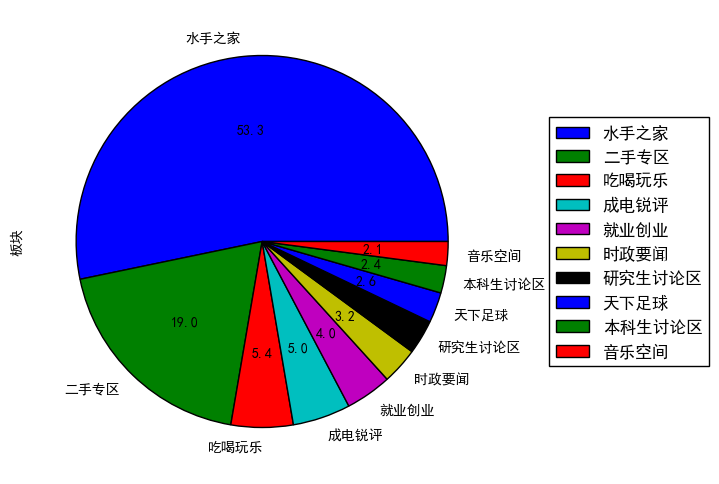

In [21]:
df_all_posts['板块'].value_counts()[:10].plot(kind='pie', figsize=(6, 6), autopct="%.1f") \
    .legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

### 回复最多的帖子

In [27]:
df_all_posts.sort_values(by='回复数', ascending=False)[:10][['标题','回复数']]

,标题,回复数
0,【八方贺畔】清水河畔8周年抢楼帖【万层大楼拔地起】,102057
0,清水河畔官方大红3号楼 【请遵守版规】,100152
0,清水河畔官方大红1号楼 【请遵守版规】,100105
0,【河畔三周年庆】抢水——自助福利楼（10W以后锁定并更换至2号楼）,100066
0,清水河畔官方大红4号楼 【请遵守版规】,100018
0,【五动青春】清水河畔五周年庆典水区活动专场 抢水楼（自助领奖）②号楼,100001
0,“五动青春”清水河畔五周年庆典水区活动专场 抢水楼（自助领奖）,100000
0,清水河畔官方大红2号楼 【请遵守版规】,100000
0,清水河畔官方大红8号楼【请遵守版规】,99999
0,元旦抢楼贴,99995


### 非水区查看最多的帖子

In [28]:
df_all_posts.sort_values(by='查看数', ascending=False)[:10][['标题','查看数']]

,标题,查看数
0,乡村岁月,542535
0,【全攻略】【如何不绑定手机办理宽带】,321692
0,”肆水年华“清水河畔四周年庆典水区活动专场 抢水楼（自助领奖）,268949
0,“五动青春”清水河畔五周年庆典水区活动专场 抢水楼（自助领奖）,255366
0,【五动青春】清水河畔五周年庆典水区活动专场 抢水楼（自助领奖）②号楼,250782
0,国庆节散水楼（请自助领奖）请勿纯表情纯水,246554
0,元旦抢楼贴,243159
0,【河畔三周年庆】抢水——自助福利楼（10W以后锁定并更换至2号楼）,241877
0,迎中秋国庆，散水活动~,240617
0,清水河畔论坛新手导航Ver1.0,237322
